In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [74]:
ff_data_list = []

for year in range(2002, 2019):
    ff_data = pd.read_csv('FF offense '+str(year)+'.csv')
    ff_data['YEAR'] = year
    ff_data = ff_data[:150]
    
    # Remove injury designation from NAME column.
    for N in ff_data.NAME:
        if N[-2:] == ' P' or N[-2:] == ' O' or N[-2:] == ' Q' or N[-2:] == ' D':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-2])
        if N[-3:] == ' IR':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-3])
        if N[-4:] == ' SUS':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-4])
            
    # Correct innaccurate position labels in POS column    
    no_qb = ff_data[ff_data.POS != 'QB']
    no_qb = no_qb[no_qb['PASS YDS'] > 106]
    index_ = no_qb.index.values
    
    for p in no_qb.POS:
        no_qb.POS = no_qb.POS.replace(p, 'QB')
        
    for i in index_:
        ff_data.loc[i] = no_qb.loc[i]
         
    ff_data_list.append(ff_data)

ff_data_list.reverse()
ALL = pd.concat(ff_data_list)
ALL = ALL.reset_index(drop=True)
ALL = ALL[ALL.POS != 'FB']
positions = list(ALL['POS'])
# ALL = ALL[['YEAR', 'RANK', 'NAME', 'TEAM', 'POS', 'PTS']]
stat_matrix = ALL.drop(columns=['POS', 'TEAM', 'PTS', 'RANK', 'GMS', 'YEAR'])
stat_matrix = stat_matrix.set_index('NAME')

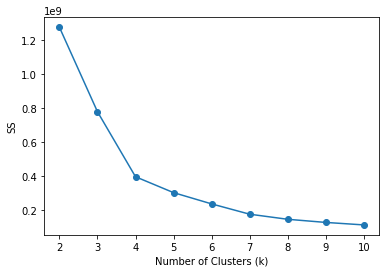

In [75]:
k_range = range(2,11)
SS = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(stat_matrix)
    SS.append(KM.inertia_)
    
plt.plot(k_range, SS, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [76]:
for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(stat_matrix)
    silhouette_avg = silhouette_score(stat_matrix, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.7459918592872101
For n_clusters = 3 The average silhouette_score is : 0.6249124774846647
For n_clusters = 4 The average silhouette_score is : 0.6288375516360286
For n_clusters = 5 The average silhouette_score is : 0.6209279593979589
For n_clusters = 6 The average silhouette_score is : 0.5683749938635263
For n_clusters = 7 The average silhouette_score is : 0.5316708956850712
For n_clusters = 8 The average silhouette_score is : 0.5212826412004119
For n_clusters = 9 The average silhouette_score is : 0.5181887518661138
For n_clusters = 10 The average silhouette_score is : 0.4943493225214256
Optimal KMeans n_clusters parameter: 2


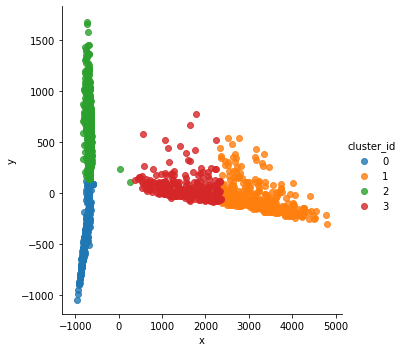

In [203]:
# cluster_df = stat_matrix.copy()

# pca = PCA(n_components=2)
# XY = pca.fit_transform(cluster_df)

# KM = KMeans(n_clusters=4)
# labels = KM.fit_predict(cluster_df)

# cluster_df['cluster_id'] = labels
# cluster_df['POS'] = positions
# cluster_df['x'] = XY[:,0]
# cluster_df['y'] = XY[:,1]

# sns.lmplot(data=cluster_df, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, legend_out=True)
# plt.show()

Results from n_clusters = 4 <br>
0 = Pass Catchers <br>
1 = Good QB's (Pass Yds > 3000) <br>
2 = Rushers <br>
3 = Bad QB's (Pass Yds < 3001)

In [221]:
cluster_df[cluster_df.cluster_id == 2].sort_values('PASS YDS', ascending=False).head()

,PASS YDS,PASS TDS,INT,RUSH YDS,RUSH TDS,REC,REC YDS,REC TDS,FUM LST,PTS / GM,YEAR,cluster_id,POS,x,y
NAME,,,,,,,,,,,,,,,
Mike McMahon,874,7,9,96,3,1,7,0,0,9.4,2002,2,QB,261.734448,107.595557
Tim Tebow,654,5,3,227,6,0,0,0,0,11.0,2010,2,QB,40.617049,233.213350
Christian McCaffrey,50,1,0,1098,7,107,867,6,1,17.4,2018,2,RB,-757.313117,479.348571
LaDainian Tomlinson,47,3,0,1462,18,51,370,2,1,19.7,2005,2,RB,-685.541694,1064.151866
Ronnie Brown,41,1,0,916,10,33,254,0,1,11.3,2008,2,RB,-642.640824,687.857254


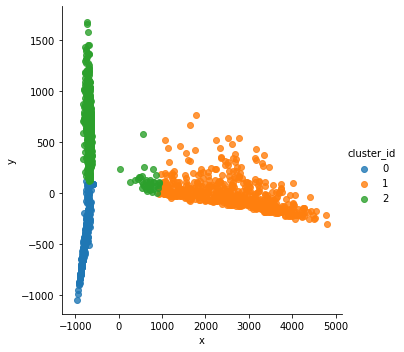

In [209]:
# cluster_df2 = stat_matrix.copy()

# pca = PCA(n_components=2)
# XY = pca.fit_transform(cluster_df2)

# KM = KMeans(n_clusters=3)
# labels = KM.fit_predict(cluster_df2)

# cluster_df2['cluster_id'] = labels
# cluster_df2['POS'] = positions
# cluster_df2['x'] = XY[:,0]
# cluster_df2['y'] = XY[:,1]

# sns.lmplot(data=cluster_df2, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, legend_out=True)
# plt.show()

In [218]:
d = cluster_df2[cluster_df2.cluster_id == 2]
d[d.POS != 'RB'].head()

,PASS YDS,PASS TDS,INT,RUSH YDS,RUSH TDS,REC,REC YDS,REC TDS,FUM LST,PTS / GM,YEAR,cluster_id,POS,x,y
NAME,,,,,,,,,,,,,,,
Lamar Jackson,1201,6,3,695,5,0,0,0,4,9.8,2018,2,QB,554.208086,576.648889
Jeff Driskel,1003,6,2,130,2,0,0,0,1,9.5,2018,2,QB,387.924585,130.529624
CJ Beathard,1430,4,6,136,3,0,0,0,2,12.7,2017,2,QB,806.672046,106.362581
Tavon Austin,0,0,0,434,4,52,473,5,2,8.8,2015,2,WR,-699.764524,171.605935
Johnny Manziel,1500,7,5,230,0,0,0,0,3,10.6,2015,2,QB,870.716340,178.036885


Results from n_clusters = 3 <br>
0 = Pass Catchers <br>
1 = QB's <br>
2 = Rushers (and lackluster QB's who run)

In [66]:
WR_TE = ALL.copy()
WR_TE = WR_TE[WR_TE.POS != 'QB']
WR_TE = WR_TE[WR_TE.POS != 'RB']
WR_TE_positions = list(WR_TE['POS'])
WR_TE = WR_TE.drop(columns=['POS', 'TEAM', 'PTS', 'RANK', 'GMS'])
WR_TE = WR_TE.set_index('NAME')
WR_TE.head()

,PASS YDS,PASS TDS,INT,RUSH YDS,RUSH TDS,REC,REC YDS,REC TDS,FUM LST,PTS / GM,YEAR
NAME,,,,,,,,,,,
Tyreek Hill,0,0,0,151,1,87,1479,12,0,15.1,2018
Antonio Brown,0,0,0,0,0,104,1297,15,0,14.6,2018
Davante Adams,0,0,0,0,0,111,1386,13,0,14.6,2018
DeAndre Hopkins,0,0,0,-7,0,115,1572,11,2,13.7,2018
Julio Jones,0,0,0,12,0,113,1677,8,2,13.3,2018


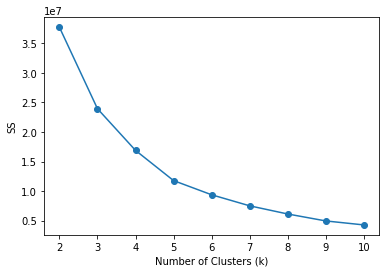

In [43]:
k_range = range(2,11)
SS = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(WR_TE)
    SS.append(KM.inertia_)
    
plt.plot(k_range, SS, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [45]:
for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(WR_TE)
    silhouette_avg = silhouette_score(WR_TE, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.5805226909841934
For n_clusters = 3 The average silhouette_score is : 0.48940033575972625
For n_clusters = 4 The average silhouette_score is : 0.49042743260034105
For n_clusters = 5 The average silhouette_score is : 0.5001291853637616
For n_clusters = 6 The average silhouette_score is : 0.45864909511240237
For n_clusters = 7 The average silhouette_score is : 0.4495212110332887
For n_clusters = 8 The average silhouette_score is : 0.4654966964423804
For n_clusters = 9 The average silhouette_score is : 0.4575291602098361
For n_clusters = 10 The average silhouette_score is : 0.44525655044345663
Optimal KMeans n_clusters parameter: 2


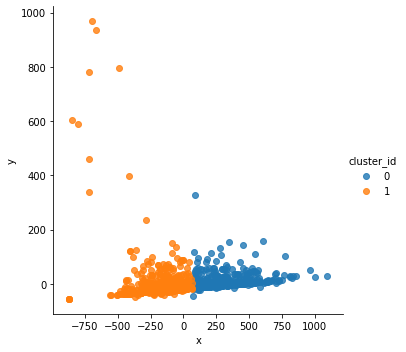

In [30]:
# pca = PCA(n_components=2)
# XY = pca.fit_transform(WR_TE)

# KM = KMeans(n_clusters=2)
# labels = KM.fit_predict(WR_TE)

# WR_TE['cluster_id'] = labels
# WR_TE['POS'] = WR_TE_positions
# WR_TE['x'] = XY[:,0]
# WR_TE['y'] = XY[:,1]

# sns.lmplot(data=WR_TE, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, legend_out=True)
# plt.show()

In [31]:
print(WR_TE[WR_TE.cluster_id == 0].describe())
print(WR_TE[WR_TE.cluster_id == 1].describe())

         PASS YDS    PASS TDS         INT    RUSH YDS    RUSH TDS         REC  \
count  435.000000  435.000000  435.000000  435.000000  435.000000  435.000000   
mean     1.202299    0.016092    0.013793   14.689655    0.062069   84.022989   
std      7.961630    0.143101    0.116766   30.578942    0.268655   15.647895   
min      0.000000    0.000000    0.000000  -30.000000    0.000000   47.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   73.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000   82.000000   
75%      0.000000    0.000000    0.000000   18.000000    0.000000   94.000000   
max    106.000000    2.000000    1.000000  342.000000    2.000000  143.000000   

           REC YDS     REC TDS     FUM LST    PTS / GM         YEAR  \
count   435.000000  435.000000  435.000000  435.000000   435.000000   
mean   1170.404598    7.772414    0.602299   10.582069  2010.225287   
std     186.620606    3.161720    0.765316    2.049548   

In [77]:
WR_TE = ALL.copy()
WR_TE = WR_TE[WR_TE.POS != 'QB']
WR_TE = WR_TE[WR_TE.POS != 'RB']
WR_TE_positions = list(WR_TE['POS'])
WR_TE = WR_TE.drop(columns=['POS', 'TEAM', 'PTS', 'RANK', 'GMS'])
WR_TE = WR_TE.set_index('NAME')

In [73]:
# from sklearn.cluster import SpectralClustering

# for n_clusters in range(2,11):
#     SC = SpectralClustering(n_clusters=n_clusters)
#     SC_labels = SC.fit_predict(matrix)
#     silhouette_avg = silhouette_score(matrix, SC_labels)
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)
#     if silhouette_avg > best:
#         best = silhouette_avg
#         best_n_clusters = n_clusters
        
# print('Optimal SpectralClustering n_clusters parameter:', best_n_clusters)